In [18]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
sys.path.append("../")
from src.data import data_preprocessing_from_yahoo_finance

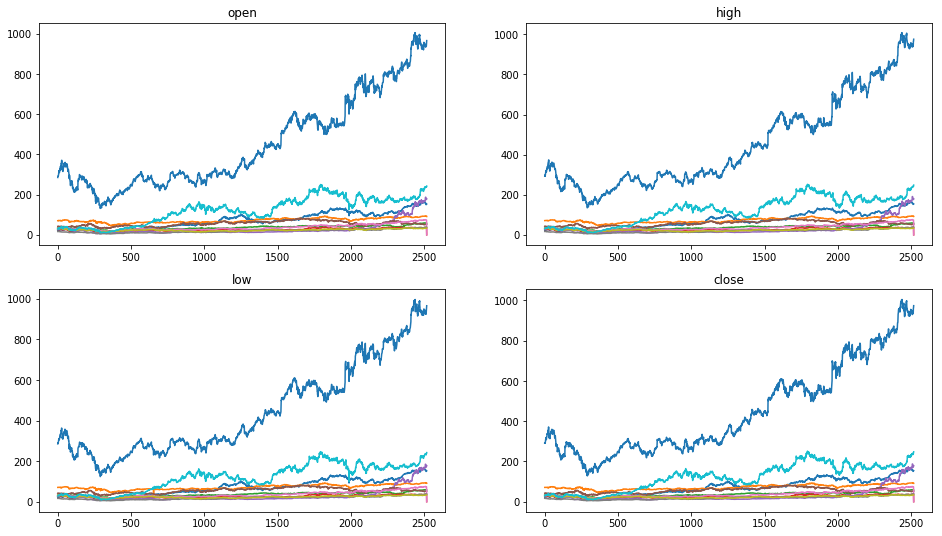

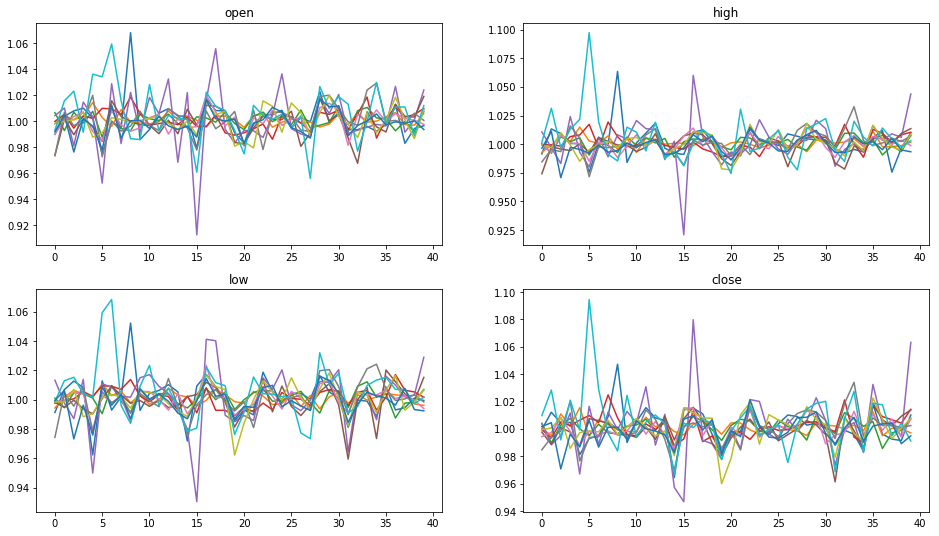

In [166]:
stock_data = np.load('../data/processed/20181004_1.npy')
data_preprocessing_from_yahoo_finance.plot_result_np(stock_data)

stock_data_scaled = stock_data[:,1:,:]/stock_data[:,:-1,:]
data_preprocessing_from_yahoo_finance.plot_result_np(stock_data_scaled[:,-50:-10,:])


In [519]:
open_np, high_np, low_np, close_np = np.split(stock_data, axis=0,
                                              indices_or_sections=4)


open_np = open_np.reshape(stock_data.shape[1],11)
high_np = high_np.reshape(-1,11)
low_np = low_np.reshape(-1,11)
close_np = close_np.reshape(-1,11)

stock_data_reshape_LSTM  = np.column_stack((open_np, high_np, low_np, close_np))
stock_data_reshape_LSTM_scaled = stock_data_reshape_LSTM[1:,:]/stock_data_reshape_LSTM[:-1,:]


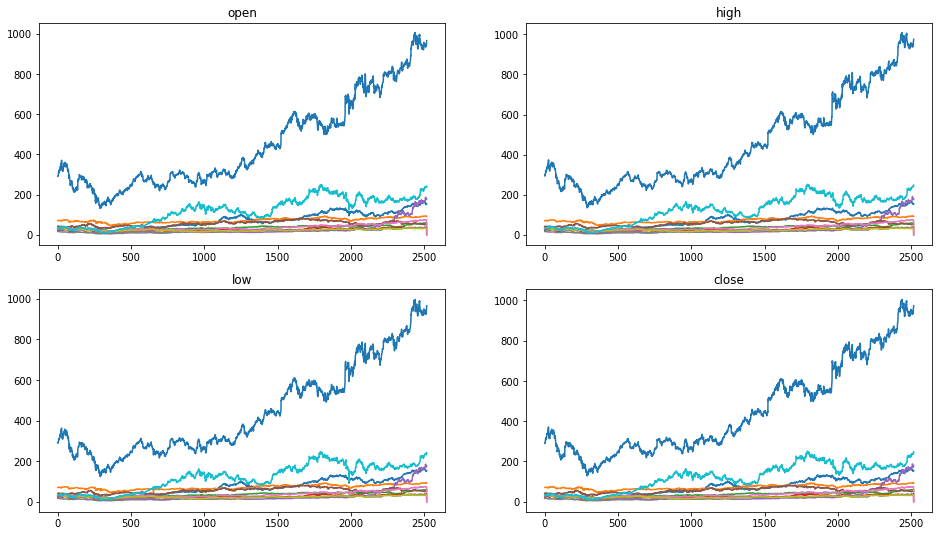

In [535]:
reengineer = []
for i in range(4):
    start = i * 11
    end = (i + 1) * 11
    reengineer.append(stock_data_reshape_LSTM_scaled[:,start:end])
    
reengineer = np.stack(reengineer, axis=0)
reengineer = np.cumprod(reengineer, axis=1)
data_preprocessing_from_yahoo_finance.plot_result_np(stock_data[:,0:1,:] * reengineer)

In [95]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import ConvLSTM2D
from keras.layers import TimeDistributed

from keras.layers.convolutional import UpSampling3D
#https://keras.io/layers/recurrent/#convlstm2d
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [82]:
print("Libraries Version Check:",
      "\n- Tensorflow version:",tf.__version__,
      "\n- Kersa version:", tf.keras.__version__,
      "\n- Padnas version:", pd.__version__)

Libraries Version Check: 
- Tensorflow version: 1.10.0 
- Kersa version: 2.1.6-tf 
- Padnas version: 0.23.4


In [537]:
stock_data_reshape_LSTM.shape

(2519, 44)

In [46]:
train = stock_data_scaled[:,:1999,:]
test = stock_data_scaled[:,2000:,:]

In [53]:
def batch_generator(batch_size, data, X_length, Y_length):
    """
    Generator function for creating random batches of training-data.
    """
    n_channel = data.shape[0]
    n_data_point = data.shape[1]
    n_stock = data.shape[2]

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, n_channel, X_length, n_stock)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, n_channel, Y_length, n_stock)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(n_data_point - X_length - Y_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = data[:,idx:idx+X_length,:]
            y_batch[i] = data[:,idx+X_length:idx+X_length+Y_length,:]
        
        yield (x_batch, y_batch)

In [55]:
batch_size = 256
sequence_length = 24 * 7 * 8
generator = batch_generator(batch_size=batch_size,
                            data = train,
                            X_length = 100,
                            Y_length = 20)

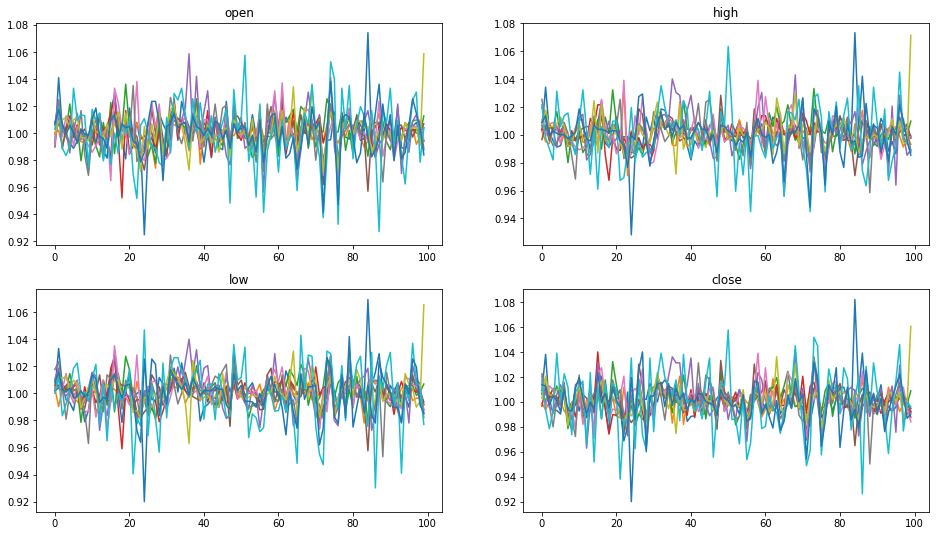

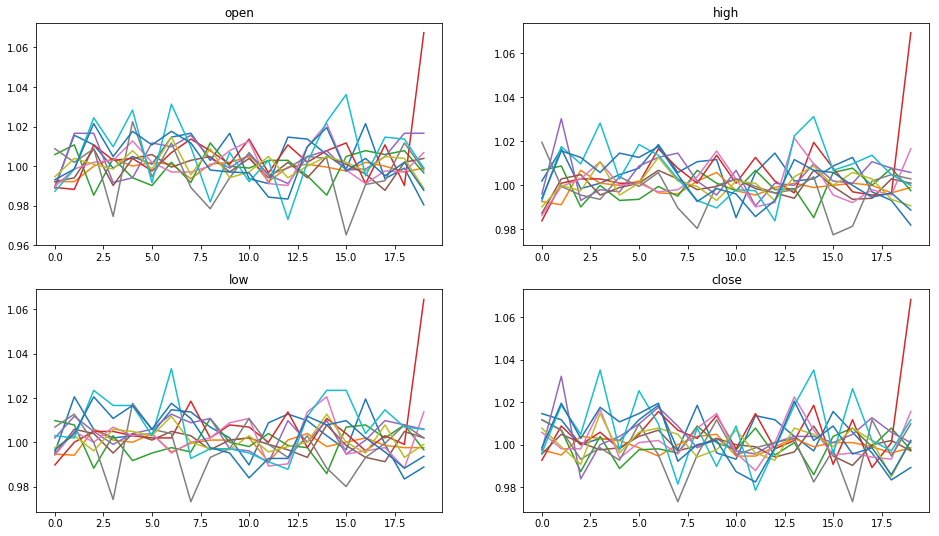

In [62]:
x_batch, y_batch = next(generator)
data_preprocessing_from_yahoo_finance.plot_result_np(x_batch[0])
data_preprocessing_from_yahoo_finance.plot_result_np(y_batch[0])

In [64]:
x_batch[0].shape

(4, 100, 11)

In [98]:
model = Sequential()

# model.add(TimeDistributed(Dense(1)))
# model.add(ConvLSTM2D(filters = 4*20*11,
#                      kernel_size = (10,11), # (row, col)
#                      strides = (1,1), 
#                      padding = 'same',
#                      data_format = 'channels_first', 
#                      use_bias = True))
# model.add(Activation(relu))

# model.add(TimeDistributedDense(20, ))
# model.add(Reshape((boxsize,boxsize,boxsize)))